In [4]:
import numpy
from keras.datasets import imdb
from matplotlib import pyplot
# load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = numpy.concatenate((X_train, X_test), axis=0)
y = numpy.concatenate((y_train, y_test), axis=0)

In [5]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000,)
(50000,)


In [6]:
# Summarize number of classes
print("Classes: ")
print(numpy.unique(y))

Classes: 
[0 1]


In [7]:
# Summarize number of words
print("Number of words: ")
print(len(numpy.unique(numpy.hstack(X))))

Number of words: 
88585


Review length: 
Mean 234.76 words (172.911495)


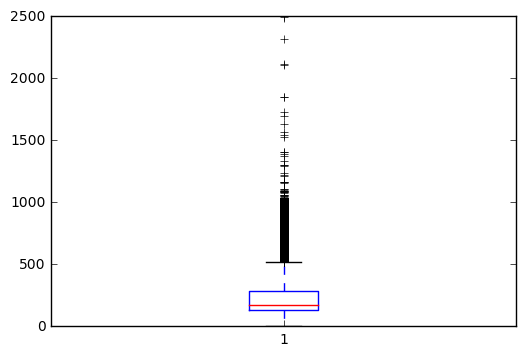

In [8]:
# Summarize review length
print("Review length: ")
result = map(len, X)
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [13]:
# MLP for the IMDB problem
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [14]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
test_split = 0.33
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)

In [15]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [16]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 32)       160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 16000)         0           embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 250)           4000250     flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             251         dense_1[0][0]                    
Total params: 4160501
_____________________________________________________________________

In [17]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 25s - loss: 0.5123 - acc: 0.7162 - val_loss: 0.3044 - val_acc: 0.8690
Epoch 2/2
25000/25000 [==============================] - 25s - loss: 0.2015 - acc: 0.9220 - val_loss: 0.3010 - val_acc: 0.8754
Accuracy: 87.54%


## One-Dimensional Convolutional Neural Network Model for the IMDB Dataset

In [18]:
# CNN for the IMDB problem
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [19]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
test_split = 0.33
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)
# pad dataset to a maximum review length in words
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [20]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 500, 32)       160000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 500, 32)       3104        embedding_2[0][0]                
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 250, 32)       0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 8000)          0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

In [21]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 53s - loss: 0.4258 - acc: 0.7762 - val_loss: 0.2853 - val_acc: 0.8802
Epoch 2/2
25000/25000 [==============================] - 53s - loss: 0.2172 - acc: 0.9153 - val_loss: 0.2813 - val_acc: 0.8830
Accuracy: 88.30%
